In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
from sklearn import manifold


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
if not os.path.exists('../data/lsaTestData.tar.gz'):
    !wget https://github.com/brian-cleary/LatentStrainAnalysis/raw/master/testData.tar.gz -O ../data/lsaTestData.tar.gz

In [5]:
!mkdir ../sandbox/lsaTestData_lsh

In [4]:
os.chdir("../sandbox/lsaTestData_lsh/")

In [7]:
!tar xf ../../data/lsaTestData.tar.gz >  /dev/null  2>&1

In [8]:
!cat original_reads/SRR*.fastq > data.fastq

In [9]:
!python ../../fastqToSeq.py -i data.fastq -o data.seq

In [5]:
!python ../../scripts/fastseq/hashSeq.py -i data.seq --hash lsh -o data.fnv -k 15

2019-01-07 12:53:03,603 - hashSeq - INFO - start converting...
2019-01-07 12:53:03,603 - hashSeq - INFO - parameters: {'out_file': 'data.fnv', 'f': <function f at 0x7f6b3e78bf50>, 'hash_fun': 'lsh', 'bucket': 20000000, 'batch_size': 100000, 'hash_size': 22, 'kmer_size': 15, 'n_thread': 7, 'in_file': 'data.seq'}
2019-01-07 12:53:03,603 - hashSeq - INFO - creating hash ...
100%|████████████████████████████████████████| 660/660 [00:02<00:00, 246.37it/s]
2019-01-07 12:53:06,336 - hashSeq - INFO - finish creating hash ...
100%|█████████████████████████████████| 100000/100000 [01:05<00:00, 1519.45it/s]
2019-01-07 12:54:17,806 - hashSeq - INFO - written 100000 lines
100%|█████████████████████████████████| 100000/100000 [01:19<00:00, 1251.56it/s]
2019-01-07 12:55:43,120 - hashSeq - INFO - written 200000 lines
100%|████████████████████████████████████████| 374/374 [00:01<00:00, 372.68it/s]
2019-01-07 12:55:44,220 - hashSeq - INFO - written 200374 lines
2019-01-07 12:55:44,226 - hashSeq - INFO -

In [11]:
!../../fastseq skipgram -input data.fnv -output data.fnv.enc

Read 16M words
Number of words:  468950
Number of labels: 0
Progress: 100.0% words/sec/thread:   36471 lr:  0.000000 loss:  1.560639 ETA:   0h 0m


In [6]:
def read_embedding(fname):
    with open(fname) as fin:
        lines=list(fin)
    assert len(lines)>1
    first_line=lines[0]
    num_word, dim_vec = [int(u) for u in first_line.split(" ")]
    assert len(lines)==num_word+1
    ret ={}
    for line in lines[1:]:
        lst = line.strip().split(" ")
        assert len(lst)==dim_vec+1, line
        if lst[0]=='</s>': continue
        word = int(lst[0])
        vec = np.array([float(u) for u in lst[1:]])
        ret[word]=vec
    return ret,dim_vec

In [13]:
embedding,dim_vec = read_embedding("data.fnv.enc.vec")

In [14]:
seqvectors = []
with open("data.fnv") as fin:
    lines = list(fin)
for i,line in enumerate(lines):
    words = [int(u) for u in line.strip().split(" ")]
    vec = [embedding[u] for u in words if u in embedding]
    seqvectors.append(np.mean(vec,0) if len(vec)>0 else None)#np.zeros([dim_vec],dtype=np.float32))
    #if i>10: break
        
    

In [15]:
seqvectors[:2]

[array([ 0.29847115,  0.17759234, -0.1871727 ,  0.00182031,  0.13710304,
         0.14619992, -0.10608838, -0.07458906, -0.04056433,  0.21255002,
         0.1271515 , -0.06568848,  0.04804541,  0.07146542, -0.10919563,
         0.16836467, -0.14794033, -0.08886195,  0.12926109, -0.00221903,
        -0.06614337,  0.16546057,  0.07460368, -0.06686607,  0.07926664,
         0.09465166, -0.05618182, -0.04265863, -0.05864494, -0.20700843,
        -0.2332153 , -0.24554379, -0.0479159 ,  0.0026165 ,  0.00838554,
         0.02959314,  0.20056617,  0.03325158,  0.1564405 , -0.15336107,
         0.14539915,  0.18646615, -0.31079705,  0.06892774,  0.22143311,
         0.21037925, -0.23936924,  0.04762014,  0.10569446, -0.17816414,
         0.14582823, -0.19854759, -0.10755751,  0.23320777, -0.03446127,
         0.09424053, -0.27220033,  0.04101645, -0.16974555, -0.0973909 ,
         0.19019972,  0.06891098, -0.11923497, -0.16202723,  0.19916235,
        -0.06546791,  0.12303008,  0.03168827, -0.1

In [16]:
seqs = pd.read_csv("data.seq",sep='\t', header=None, usecols=[0,1],index_col=0)

In [17]:
seqs.columns=['id']

In [18]:
seqs['spike']=seqs['id'].map(lambda u: u.startswith("Spike"))

In [19]:
seqs[seqs.spike].head()

,id,spike
0,,
10001,Spike.10000000000.1 gi|695198550|ref|NG_035027...,True
10002,Spike.10000000000.2 gi|695198550|ref|NG_035027...,True
10003,Spike.10000000001.1 gi|695198550|ref|NG_035027...,True
10004,Spike.10000000001.2 gi|695198550|ref|NG_035027...,True
10005,Spike.10000000002.1 gi|695198550|ref|NG_035027...,True


In [20]:
len(seqs),len(seqvectors)

(200374, 200374)

In [21]:
seqs['vec']=seqvectors

In [22]:
seqs.head()

,id,spike,vec
0,,,
1,SRR492065.1.1 HWI-EAS385_0095_FC:2:1:6702:1434...,False,"[0.2984711475409837, 0.17759233934426225, -0.1..."
2,SRR492065.1.2 HWI-EAS385_0095_FC:2:1:6702:1434...,False,"[0.3140682413793103, 0.20883930689655178, -0.1..."
3,SRR492065.2.1 HWI-EAS385_0095_FC:2:1:6931:1435...,False,"[0.2892904677419356, 0.1846664553225806, -0.16..."
4,SRR492065.2.2 HWI-EAS385_0095_FC:2:1:6931:1435...,False,"[0.2969524838709678, 0.195218829032258, -0.127..."
5,SRR492065.3.1 HWI-EAS385_0095_FC:2:1:9984:1431...,False,"[0.3076308951612903, 0.1931182661290323, -0.20..."


In [23]:
seqs['vec'].isnull().mean()

0.0

In [24]:
seqs[seqs.spike]['vec'].isnull().mean()

0.0

In [25]:
seqs=seqs[~seqs['vec'].isnull()]

In [26]:
seqs.shape,np.sum(seqs['spike']),seqs['spike'].mean()

((200374, 3), 20374, 0.10167985866429777)

In [27]:
seqs['vec'].map(lambda u: len(u)).value_counts()

100    200374
Name: vec, dtype: int64

In [28]:
subseqs=seqs.sample(n=1000)
subseqs.shape,np.sum(subseqs['spike']),subseqs['spike'].mean()

((1000, 3), 91, 0.091)

In [29]:
X=np.array(list(subseqs['vec'].values))
X.shape

(1000, 100)

In [30]:
tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30)

In [31]:
%time Y = tsne.fit_transform(X)

CPU times: user 26.1 s, sys: 964 ms, total: 27.1 s
Wall time: 27.1 s


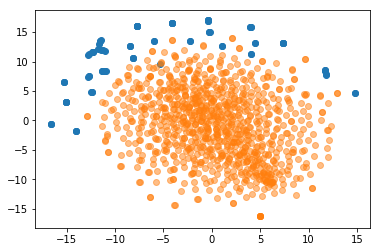

In [32]:
plt.scatter(Y[subseqs['spike']][:,0],Y[subseqs['spike']][:,1],alpha=1)
plt.scatter(Y[~subseqs['spike']][:,0],Y[~subseqs['spike']][:,1],alpha=0.5)

In [33]:
tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity=100)

In [34]:
%time Y = tsne.fit_transform(X)

CPU times: user 39.1 s, sys: 980 ms, total: 40.1 s
Wall time: 40.1 s


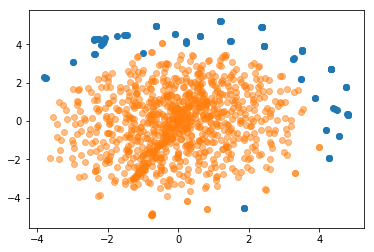

In [35]:
plt.scatter(Y[subseqs['spike']][:,0],Y[subseqs['spike']][:,1],alpha=1)
plt.scatter(Y[~subseqs['spike']][:,0],Y[~subseqs['spike']][:,1],alpha=0.5)